In this notebook we analyze if the impact of Covid-19 has had a detremental affect on the results of home teams where their fans have not been allowed to attend games.

We will scrape match data from the 2019-2020 season from the following leagues:



1.   English Premier League
2.   Spanish La Liga
3.   German Bundesliga
4.   Italian Serie A

The data will be sourced from the following website: https://fbref.com/


In [1]:
import urllib.request
import pandas as pd
import numpy as np


def get_df_from_url(url, league_name):
  '''
  This function takes a url and finds the table we need for analysis. This table 
  is used to set the dataframe which will be returned from the function. The league
  name is added in a new column also.

  url: URL containing the data
  league_name: League name to be added to the df object
  return: Dataframe object.
  '''

  print("Start get_df_from_url")

  html_content = urllib.request.urlopen(url).read()

  # There are two header rows so only use the second
  #html_table = pd.read_html(html_content, attrs={'id': 'stats_shooting'}, header=[1])
  html_table = pd.read_html(html_content)

  df = html_table[0]

  df['league'] = league_name

  print("Ended get_df_from_url")

  return df


def get_filtered_df(df):
  '''
  This function takes a dataframe and returns the columns we are interested in. It 
  also filters out rows where the players position is not a striker.

  df: DataFrame to be filtered 
  return: Filtered dataframe object.
  '''

  print("Start get_filtered_df")
  
  filtered_df = df[["Home", "Score", "Attendance", "league"]]
  
  print("Ended get_filtered_df")

  return filtered_df


def get_formatted_df(df):
  '''
  This function takes a dataframe and returns a formatted dataframe where the score 
  column has been split up into home score and away score. Null values in the 
  attendance column are also replaced with zero. The website the data is scraped 
  from sets this value as a null for when there is no attendance at a match.

  df: DataFrame to be formatted 
  return: Formatted dataframe object.
  '''

  print("Start get_formatted_df")

  df[['home_score','away_score']] = df['Score'].str.split('–',expand=True)

  df['attendance'] = df['attendance'].replace(np.nan, 0)
  
  print("Ended get_formatted_df")

  return df


# Dictionary of leagues with ID and Name Properties
leagues_to_process = [
  {"ID": "9/3232", "name": "Premier-League"},
  {"ID": "12/3239", "name": "La-Liga"},
  {"ID": "20/3248", "name": "Bundesliga"},
  {"ID": "11/3260", "name": "Serie-A"}
]

master_df = pd.DataFrame(columns=['score', 'attendance'])

for league in leagues_to_process:
  print("Processing ", league["name"])

  # Insert current season to url so we can scrape the data
  url = "https://fbref.com/en/comps/{}/schedule/2019-2020-{}-Scores-and-Fixtures"
  league_url = url.format(league["ID"], league["name"])
  print(league_url)
  df = get_df_from_url(league_url, league["name"])

  filtered_df = get_filtered_df(df)

  master_df = master_df.append(filtered_df)

  master_df = get_formatted_df(master_df)
  

print(master_df)

Processing  Premier-League
https://fbref.com/en/comps/9/3232/schedule/2019-2020-Premier-League-Scores-and-Fixtures
Start get_df_from_url
Ended get_df_from_url
Start get_filtered_df
Ended get_filtered_df
Start get_formatted_df
Ended get_formatted_df
Processing  La-Liga
https://fbref.com/en/comps/12/3239/schedule/2019-2020-La-Liga-Scores-and-Fixtures
Start get_df_from_url
Ended get_df_from_url
Start get_filtered_df
Ended get_filtered_df
Start get_formatted_df
Ended get_formatted_df
Processing  Bundesliga
https://fbref.com/en/comps/20/3248/schedule/2019-2020-Bundesliga-Scores-and-Fixtures
Start get_df_from_url
Ended get_df_from_url
Start get_filtered_df
Ended get_filtered_df
Start get_formatted_df
Ended get_formatted_df
Processing  Serie-A
https://fbref.com/en/comps/11/3260/schedule/2019-2020-Serie-A-Scores-and-Fixtures
Start get_df_from_url
Ended get_df_from_url
Start get_filtered_df
Ended get_filtered_df
Start get_formatted_df
Ended get_formatted_df
    score  attendance         Home  .

Here we create new columns and set the values for game result

In [2]:
points_conditions = [
    (master_df['home_score'] > master_df['away_score']),
    (master_df['home_score'] < master_df['away_score']),
    (master_df['home_score'] == master_df['away_score'])
]

points_values = [3, 0, 1]

master_df['points_won_home_team'] = np.select(points_conditions, points_values)

fans_conditions = [
    (master_df['Attendance'] > 0),
    (master_df['Attendance'] == 0)   
]

fan_values = [1, 0]

master_df['fans?'] = np.select(fans_conditions, fan_values)

print(master_df)

    score  attendance         Home  ... away_score  points_won_home_team fans?
0     NaN         0.0    Liverpool  ...          1                     3     1
1     NaN         0.0     West Ham  ...          5                     0     1
2     NaN         0.0      Burnley  ...          0                     3     1
3     NaN         0.0      Watford  ...          3                     0     1
4     NaN         0.0  Bournemouth  ...          1                     1     1
..    ...         ...          ...  ...        ...                   ...   ...
416   NaN         0.0         SPAL  ...          3                     0     0
417   NaN         0.0        Genoa  ...          0                     3     0
418   NaN         0.0        Lecce  ...          4                     0     0
419   NaN         0.0      Bologna  ...          1                     1     0
420   NaN         0.0     Sassuolo  ...          1                     0     0

[1603 rows x 10 columns]


In [3]:
avg_df = master_df.groupby(['fans?'], as_index=False)['points_won_home_team'].mean()
print(avg_df)

   fans?  points_won_home_team
0      0              1.078534
1      1              1.567961


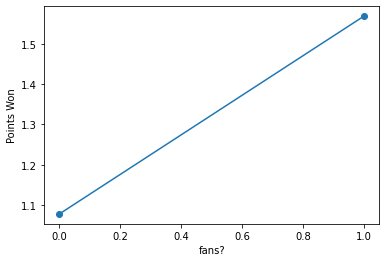

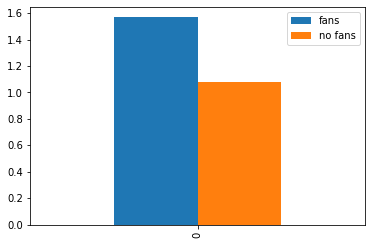

In [4]:
%matplotlib inline
from pylab import *

plt.scatter(avg_df['fans?'], avg_df['points_won_home_team'])

plt.xlabel('fans?')
plt.ylabel('Points Won')
plt.plot(avg_df['fans?'], avg_df['points_won_home_team'])
plt.show()

fans_df = avg_df[avg_df['fans?'] == 1]['points_won_home_team']
no_fans_df = avg_df[avg_df['fans?'] == 0]['points_won_home_team']
plotdata = pd.DataFrame({
    "fans":fans_df.to_numpy(),
    "no fans":no_fans_df.to_numpy()
    },
    index = None
)
plotdata.plot(kind="bar")

In [5]:
league_avg_df = master_df.groupby(['league', 'fans?'], as_index=False).mean('points_won_home_team')

print(league_avg_df)

           league  fans?  attendance    Attendance  points_won_home_team
0      Bundesliga      0         0.0           NaN              0.842975
1      Bundesliga      1         0.0  40868.654709              1.511211
2         La-Liga      0         0.0           NaN              1.100000
3         La-Liga      1         0.0  29234.557621              1.717472
4  Premier-League      0         0.0           NaN              1.137405
5  Premier-League      1         0.0  39314.222222              1.593750
6         Serie-A      0         0.0           NaN              1.181287
7         Serie-A      1         0.0  26915.904000              1.428000


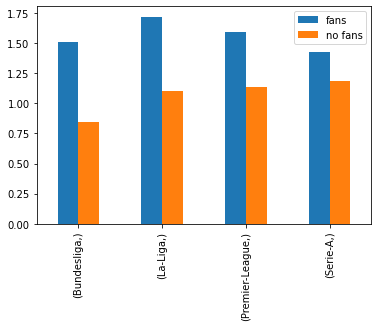

In [6]:
from matplotlib.pyplot import bar

fans_df = league_avg_df[league_avg_df['fans?'] == 1]['points_won_home_team']
no_fans_df = league_avg_df[league_avg_df['fans?'] == 0]['points_won_home_team']

plotdata = pd.DataFrame({
    "fans":fans_df.to_numpy(),
    "no fans":no_fans_df.to_numpy()
    }, 
    index=[league_avg_df.league.unique()]
)

plotdata.plot(kind="bar")